# File: exercise_1.py
Description: Analyze the following Run I CMS H -> 4l data:
```
   N        = 25
   b_hat_zz =  6.8 +/- 0.3
   b_hat_zx =  2.6 +/- 0.4
   s_hat    = 17.3 +/- 1.3 (mH = 125 GeV)
            = 19.6 +/- 1.3 (mH = 126 GeV)
```
 which pertains to data in the range 121.5 <= mH <= 130.5 GeV
 for 7 and 8 TeV data.
 
 - Created: 18-Dec-2015 CMSDAS 2016, LPC Fermilab HBP
 - Updated: 10-Jan-2019 CMSDAS 2019, LPC Fermilab JMD

In [1]:
import os,sys,re
from time import sleep
import math
import ROOT as rt

Welcome to JupyROOT 6.12/07


In [6]:
#-------------------------------------------------------------        
def createWorkspace(wsname, wsfilename):
    # The most convenient way to use RooFit/RooStats is to 
    # make a workspace so that we can use its factory method
    wspace = rt.RooWorkspace(wsname)

    #-----------------------------------------------------
    # Create parameters
    #
    # Use the factory method of the RooWorkspace to create
    # parameters
    #
    # syntax:
    #        <name>[value, min-value, max-value]
    #-----------------------------------------------------
    # observations
    params = [('N',       25,     0,  50),
    # ZZ background estimate        
              ('b_hat_zz', 6.8,   0,  15),
              ('db_zz',    0.3,   0,   5),
    # Z+X background estimate
              ('b_hat_zx', 2.6,   0,  15),
              ('db_zx',    0.3,   0,   5),
    # signal estimate (mH=125 GeV)       
              ('s_hat',   17.3,   0,  25),
              ('ds',       1.3,   0,   5),
    # nuisance parameters
              ('b_zz',    6.8,    0,  15),
              ('b_zx',    2.6,    0,  10),
              ('s',      17.3,    0,  25),
    # parameter of interest
              ('mu',      1.0,    0,   4)]

    for t in params:
        cmd = '%s[%f, %f, %f]' % t
        wspace.factory(cmd)        
    wspace.var('mu').SetTitle('#mu')

    # fix all background and signal parameters
    for t in params[1:-4]:
        name = t[0]
        print '=> make %8s = %5.1f constant' % (name,
                                                wspace.var(name).getVal())
        wspace.var(name).setConstant()

    #-----------------------------------------------------
    # Create expressions
    #
    # syntax:
    #        expr::<name>("expression", var1, var2, ...)
    #-----------------------------------------------------
    express = [#'B_zz("(b_hat_zz/db_zz)^2", b_hat_zz, db_zz)',
               #'tau_zz("b_hat_zz/db_zz^2", b_hat_zz, db_zz)',
               
               #'B_zx("(b_hat_zx/db_zx)^2", b_hat_zx, db_zx)',
               #'tau_zx("b_hat_zx/db_zx^2", b_hat_zx, db_zx)',
                              
               #'S("(s_hat/ds)^2",   s_hat, ds)',
               #'tau_s("s_hat/ds^2", s_hat, ds)',

               #'tau_zzb_zz("tau_zz*b_zz", tau_zz, b_zz)',
               #'tau_zxb_zx("tau_zx*b_zx", tau_zx, b_zx)',
               #'tau_ss("tau_s*s", tau_s, s)',
               'n("mu*s + b_zz + b_zx", mu, s, b_zz, b_zx)']
        
    for t in express:
        cmd = 'expr::%s' % t
        wspace.factory(cmd)

    #print '\neffective counts and scale factors'
    #print 'B_zz = %8.2f, tau_zz = %8.2f' % (wspace.function('B_zz').getVal(),
    #                                        wspace.function('tau_zz').getVal())

    #print 'B_zx = %8.2f, tau_zx = %8.2f' % (wspace.function('B_zx').getVal(),
    #                                        wspace.function('tau_zx').getVal())

    #print 'S    = %8.2f, tau_s  = %8.2f' % (wspace.function('S').getVal(),
    #                                        wspace.function('tau_s').getVal())

    #-----------------------------------------------------
    # Create pdfs
    #
    # syntax:
    #        pdf_name::<name>(var1, var2, ...)
    #
    # where the "Roo" prefix is dropped in pdf_name, e.g.
    #-----------------------------------------------------
    pdfs = [('Poisson', 'pN',    '(N, n)'),
            # Truncated Gaussian constraints (in general bad!)
            ('Gaussian','pB_zz', '(b_zz, b_hat_zz, db_zz)'),
            ('Gaussian','pB_zx', '(b_zx, b_hat_zx, db_zx)'),
            ('Gaussian','pS', '(s, s_hat, ds)'), 
            # scaled Poisson constraints (allowing non-integer B_zz)
            #('Poisson', 'pB_zz', '(B_zz, tau_zzb_zz, 1)'), 
            #('Poisson', 'pB_zx', '(B_zx, tau_zxb_zx, 1)'),
            #('Poisson', 'pS',    '(S,    tau_ss,     1)'),
           ]
    
    prodpdf = ''
    for t in pdfs:
        wspace.factory('%s::%s%s' % t)
        name = t[1]
        prodpdf += "%s, " % name
    prodpdf = prodpdf[:-2] # remove last ", "
    
    # multiply the pdfs together. use upper case PROD to
    # do this
    wspace.factory('PROD::model(%s)' % prodpdf)

    # create a prior, since one is needed in Bayesian
    # calculations
    wspace.factory('Uniform::prior({mu, s, b_zz, b_zx})')

    #-----------------------------------------------------
    # Define a few useful sets. Now we need to decide
    # whether or not to include B and S in the set obs of
    # observations. 
    #-----------------------------------------------------
    sets = [('obs',  'N'),           # observations
            ('poi',  'mu'),          # parameter of interest
            ('nuis', 's,b_zz,b_zx')] # nuisance parameters (leave no spaces)
    for t in sets:
        name, parlist = t
        wspace.defineSet(name, parlist)
    
    #-----------------------------------------------------        
    # create a dataset
    #-----------------------------------------------------    
    data = rt.RooDataSet('data', 'data', wspace.set('obs'))
    data.add(wspace.set('obs'))
    # import dataset into workspace
    # need last argument to workaround a PyROOT "feature".
    # the last argument ensures the correct version of
    # the import method is called.
    getattr(wspace, 'import')(data, rt.RooCmdArg())
        
    #-----------------------------------------------------
    # Create model configuration. This is needed for the
    # statistical analyses
    #-----------------------------------------------------
    cfg = rt.RooStats.ModelConfig('cfg')
    cfg.SetWorkspace(wspace)
    cfg.SetPdf(wspace.pdf('model'))
    cfg.SetPriorPdf(wspace.pdf('prior'))
    cfg.SetParametersOfInterest(wspace.set('poi'))
    cfg.SetNuisanceParameters(wspace.set('nuis'))

    # import model configuration into workspace
    getattr(wspace, 'import')(cfg)

    wspace.Print()
    
    # write out workspace
    wspace.writeToFile(wsfilename)

In [19]:
def analyzeWorkspace(wsname, wsfilename):

    # Open workspace file
    wsfile = rt.TFile.Open(wsfilename)

    # Get workspace
    wspace = wsfile.Get(wsname) 

    # Get data
    data = wspace.data('data')

    # Get model configuration    
    cfg  = wspace.obj('cfg')

    #-----------------------------------------------------    
    # Fit model to data
    #-----------------------------------------------------
    results = wspace.pdf('model').fitTo(data, rt.RooFit.Save())
    results.Print()
    
    #-----------------------------------------------------    
    # Compute interval based on profile likelihood
    #-----------------------------------------------------
    # suppress some (apparently) innocuous warnings
    msgservice = rt.RooMsgService.instance()
    msgservice.setGlobalKillBelow(rt.RooFit.FATAL)
        
    print 'compute interval using profile likelihood'
    plc = rt.RooStats.ProfileLikelihoodCalculator(data, cfg)
    CL  = 0.683
    plc.SetConfidenceLevel(CL)
    plcInterval= plc.GetInterval()
    lowerLimit = plcInterval.LowerLimit(wspace.var('mu'))
    upperLimit = plcInterval.UpperLimit(wspace.var('mu'))

    print '\tPL %4.1f%s CL interval = [%5.2f, %5.2f]' % \
      (100*CL, '%', lowerLimit, upperLimit)

    plcplot = rt.RooStats.LikelihoodIntervalPlot(plcInterval)      
    plccanvas = rt.TCanvas('fig_PL', 'PL', 500, 10, 850, 400)
    plccanvas.Divide(2, 1)
    plccanvas.cd(1)
    plcplot.SetRange(0,4)
    plcplot.SetMaximum(3)
    plcplot.Draw()
    
    
    
    
    # compute an 95% upper limit on mu by
    # computing a 90% central interval and
    # ignoring the lower limit
    CL = 0.90
    plc.SetConfidenceLevel(CL)
    plcInterval = plc.GetInterval()
    upperLimit = plcInterval.UpperLimit(wspace.var('mu'))

    CL = 0.95
    print '\tPL %4.1f%s upper limit = %5.2f\n' % \
      (100*CL, '%', upperLimit)      
      
    plccanvas.cd(2)
    plcplot2 = rt.RooStats.LikelihoodIntervalPlot(plcInterval)
    plcplot2.SetRange(0,4)
    plcplot2.SetMaximum(3)
    plcplot2.Draw()
    plccanvas.Update()
    
    #-----------------------------------------------------    
    # Compute interval based on Bayesian calculator
    #-----------------------------------------------------
    print 'compute interval using Bayesian calculator'
    bc = rt.RooStats.BayesianCalculator(data, cfg)
    CL  = 0.683
    bc.SetConfidenceLevel(CL)
    bcInterval = bc.GetInterval()
    lowerLimit = bcInterval.LowerLimit()
    upperLimit = bcInterval.UpperLimit()

    print '\tBayes %4.1f%s CL interval = [%5.2f, %5.2f]' % \
      (100*CL, '%', lowerLimit, upperLimit)

    # calculate posterior density at 50 points
    print "\t\t...be patient...!"
    bc.SetScanOfPosterior(50)
    bcplot = bc.GetPosteriorPlot()
    bccanvas = rt.TCanvas('fig_Bayes', 'Bayes', 500, 10, 850, 400)
    bccanvas.Divide(2, 1)
    bccanvas.cd(1)
    bcplot.Draw()
    bccanvas.Update()

    # compute an 95% upper limit on mu
    CL  = 0.950
    bc.SetConfidenceLevel(CL)
    # 0   = upper limit
    # 0.5 = central limits (default)
    # 1   = lower limit
    bc.SetLeftSideTailFraction(0)
    bcInterval = bc.GetInterval()
    upperLimit = bcInterval.UpperLimit()

    print '\tBayes %4.1f%s upper limit = %5.2f\n' % \
      (100*CL, '%', upperLimit)      

    # calculate posterior density at 50 points
    bc.SetScanOfPosterior(50)
    bcplot2 = bc.GetPosteriorPlot()
    bccanvas.cd(2)
    bcplot2.Draw()
    bccanvas.Update()

    # save canvases
    plccanvas.Draw()
    bccanvas.Draw()
    plccanvas.SaveAs('.png')
    bccanvas.SaveAs('.png')
    return plccanvas, bccanvas

In [12]:
createWorkspace('CMSDAS16', 'single_count.root')

=> make b_hat_zz =   6.8 constant
=> make    db_zz =   0.3 constant
=> make b_hat_zx =   2.6 constant
=> make    db_zx =   0.3 constant
=> make    s_hat =  17.3 constant
=> make       ds =   1.3 constant

RooWorkspace(CMSDAS16) CMSDAS16 contents

variables
---------
(N,b_hat_zx,b_hat_zz,b_zx,b_zz,db_zx,db_zz,ds,mu,s,s_hat)

p.d.f.s
-------
RooProdPdf::model[ pN * pB_zz * pB_zx * pS ] = 0.0752442
RooGaussian::pB_zx[ x=b_zx mean=b_hat_zx sigma=db_zx ] = 1
RooGaussian::pB_zz[ x=b_zz mean=b_hat_zz sigma=db_zz ] = 1
RooPoisson::pN[ x=N mean=n ] = 0.0752442
RooGaussian::pS[ x=s mean=s_hat sigma=ds ] = 1
RooUniform::prior[ x=(mu,s,b_zz,b_zx) ] = 1

functions
--------
RooFormulaVar::n[ actualVars=(mu,s,b_zz,b_zx) formula="mu*s+b_zz+b_zx" ] = 26.7

datasets
--------
RooDataSet::data(N)

named sets
----------
cfg_NuisParams:(s,b_zz,b_zx)
cfg_POI:(mu)
nuis:(s,b_zz,b_zx)
obs:(N)
poi:(mu)

generic objects
---------------
RooStats::ModelConfig::cfg



compute interval using profile likelihood
	PL 68.3% CL interval = [ 0.63,  1.22]
	PL 95.0% upper limit =  1.46

compute interval using Bayesian calculator
	Bayes 68.3% CL interval = [ 0.67,  1.28]
		...be patient...!
	Bayes 95.0% upper limit =  1.53

 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 b_zx         2.60000e+00  1.00000e+00    0.00000e+00  1.00000e+01
     2 b_zz         6.80000e+00  1.50000e+00    0.00000e+00  1.50000e+01
     3 mu           1.00000e+00  4.00000e-01    0.00000e+00  4.00000e+00
     4 s            1.73000e+01  2.50000e+00    0.00000e+00  2.50000e+01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        2000 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: fig_PL
Warning in <TCanvas::Constructor>: Deleting canvas with same name: fig_Bayes
Info in <TCanvas::Print>: png file ./fig_PL.png has been created
Info in <TCanvas::Print>: png file ./fig_Bayes.png has been created


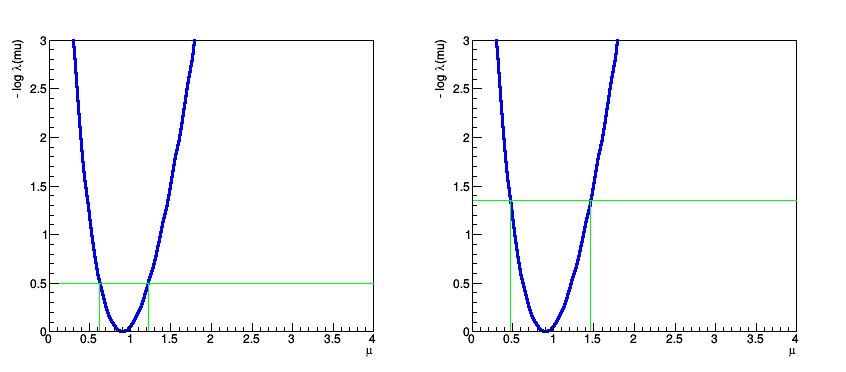

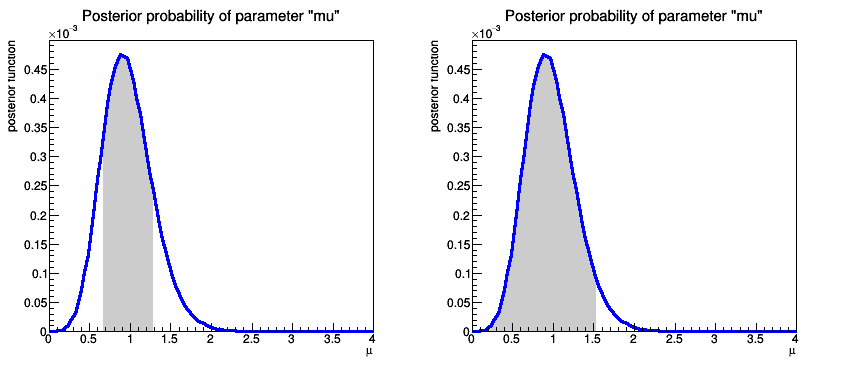

In [20]:
plccanvas, bccanvas = analyzeWorkspace('CMSDAS16', 'single_count.root')